In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6

In [2]:
data = pd.read_csv('C:\\Users\\mario\\Desktop\\UFPE\\correlacoes\\airline.csv')

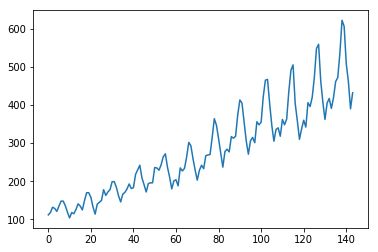

In [3]:
plt.plot(data)
plt.show()

#### Pré-processamento

In [4]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [5]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [6]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):  #começa do 1 
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [7]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

In [8]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [9]:
serie = data.values
serie_normalizada = normalizar_serie(serie)
janelas = gerar_janelas(20, serie_normalizada)
lags_acf = select_lag_acf(serie_normalizada, 20)
print(lags_acf)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]


In [10]:

x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(janelas, 0.50, perc_val = 0.25)

Particao de Treinamento: 0 61
Particao de Validacao: 61 91
Particao de Teste: 91 123


#### Treinamento e Avaliação

In [11]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec, func_activation):
    neuronios =  [1, 10, 20,  30, 40, 50, 60, 70, 80, 90, 100]
    alg_treinamento = ['lbfgs', 'adam']
    max_iteracoes = [1000]
    learning_rate = ['constant', 'adaptive']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variando a qtd de pontos utilizados na janela 
                            
                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                                
                                
                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag
    
    
    return select_model, qtd_lags_sel

# 1)

In [12]:
exec_modelo = 5 # quantidade de vezes que cada configuração será executada
modelos = {}
func_activation =  [['tanh'], ['relu']]
for func in func_activation:
    for i in range(1,31):
        print("quantidade de execuções até o momento: ", i)
        modelo, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, exec_modelo, func)
        if func[0] in modelos:
            modelos[func[0]].append((modelo, lag_sel))
        else:
            modelos[func[0]] = [(modelo, lag_sel)]

quantidade de execuções até o momento:  1


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  2


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  3


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  4


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  5


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  6


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  7


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  8


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  9


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  10


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  11


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  12


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  13


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  14


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  15


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  16


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  17


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  18


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  19


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  20


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  21


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  22


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  23


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  24


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  25


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  26


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  27


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  28


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  29


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  30


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  1


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  2


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  3


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  4


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  5


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  6


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  7


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  8


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  9


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  10


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  11


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  12


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  13


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  14


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  15


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  16


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  17


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  18


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  19


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  20


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  21


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  22


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  23


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  24


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  25


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  26


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  27


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  28


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  29


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

quantidade de execuções até o momento:  30


C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mario\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

In [41]:
predictions = {}
for key, value in modelos.items():
    for modelo, lag_sel in modelos[key]:   
        predict_test = modelo.predict(x_test[:, -lag_sel:])
        if key in predictions:   
            predictions[key].append(predict_test)
        else:
            predictions[key] = [predict_test]


In [32]:
for key, value in predictions.items():
    mse = []
    for prediction in value:
        mse.append(MSE(y_test, prediction))
    mse = np.array(mse)
    print(key+":")
    print("   MSE: ", min(mse))
    print("   mean: ", mse.mean())
    print("   deviation: ", mse.std())


tanh:
   MSE:  0.0009350337771377205
   mean:  0.001259732672550285
   deviation:  0.00024932149297837974
relu:
   MSE:  0.0008265934184559301
   mean:  0.0011820556607116599
   deviation:  0.00044969957011843924


# 2)

#### resposta: no código a baixo, fiz uma mudança no algoritmo de treinamento para stochastic gradient descent e mantive a função de ativação  da hyperbolic tan, para poder ter uma comparação. depois, mudei a função de ativação para a logistic.

#### após os testes, foi possível perceber que a mudança no algoritmo de treinamento fez perder eficiência, assim como a alteração na função de ativação

In [33]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec, func_activation):
    neuronios =  [1, 10, 20,  30, 40, 50, 60, 70, 80, 90, 100]
    alg_treinamento = ['sgd']
    max_iteracoes = [1000]
    learning_rate = ['constant', 'adaptive']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variando a qtd de pontos utilizados na janela 
                            
                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])


                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                                
                                
                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    print('Melhor MSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag
    
    
    return select_model, qtd_lags_sel

In [34]:
exec_modelo = 5 # quantidade de vezes que cada configuração será executada
modelos = {}
func_activation =  [['tanh'], ['logistic']]
for func in func_activation:
    for i in range(1,31):
        print("quantidade de execuções até o momento: ", i)
        modelo, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, exec_modelo, func)
        if func[0] in modelos:
            modelos[func[0]].append((modelo, lag_sel))
        else:
            modelos[func[0]] = [(modelo, lag_sel)]

quantidade de execuções até o momento:  1
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.005775000461349421
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.004258122472602027
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
Q

QTD de Lags: 10 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 40 Func

QTD de Lags: 2 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 90 Func.

QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 20 Func.

QTD de Lags: 19 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act tanh
Melhor MSE: 0.0023412112671747174
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act tanh
QTD de

QTD de Lags: 11 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 11 Qtd d

QTD de Lags: 18 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 30 Func

QTD de Lags: 11 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func

QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. A

QTD de Lags: 11 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 50 Func

QTD de Lags: 3 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 100 Fu

QTD de Lags: 11 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 30 Func

QTD de Lags: 4 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 70 Func.

QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.0054443680240063375
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Ne

QTD de Lags: 4 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 50 Func.

QTD de Lags: 15 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 90 Func

QTD de Lags: 3 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act tanh
Melhor MSE: 0.004292083345513526
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act tanh
QTD de 

QTD de Lags: 13 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 60 Func

QTD de Lags: 6 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act tanh
quantidade de execuções até o momento:  8
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.07781536459955264
Melhor MSE: 0.06130749825810834
Melhor MSE: 0.0385707487850211
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.03430182734008362
QTD de La

QTD de Lags: 11 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 40 Func

QTD de Lags: 3 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 80 Func.

QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func

QTD de Lags: 5 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 60 Func.

QTD de Lags: 17 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 17 Qtd de N

QTD de Lags: 6 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 30 Func.

QTD de Lags: 19 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 70 Func

Melhor MSE: 0.0064123511475707344
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de 

QTD de Lags: 14 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act tanh
Melhor MSE: 0.004320369496801641
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act tanh
QTD de 

QTD de Lags: 6 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 90 Func.

QTD de Lags: 7 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act tanh
Melhor MSE: 0.0049700246326972375
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act tanh
QTD de

QTD de Lags: 16 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 60 Func

QTD de Lags: 9 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act tanh
quantidade de execuções até o momento:  13
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.16915918123868776
Melhor MSE: 0.05005695786290056
Melhor MSE: 0.024684852705093404
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.006666941335819745
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags

QTD de Lags: 17 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 40 Func

QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func

QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.004680599652639643
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de 

QTD de Lags: 6 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act tanh
Melhor MSE: 0.0041204209502311104
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act tanh
QTD de

QTD de Lags: 16 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 16 Qtd de Ne

QTD de Lags: 8 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act tanh
Melhor MSE: 0.0045417197321661095
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act tanh
QTD de

QTD de Lags: 17 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func

QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de

QTD de Lags: 14 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 50 Func

QTD de Lags: 8 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 90 Func.

QTD de Lags: 17 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 20 Func

QTD de Lags: 7 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 70 Func.

QTD de Lags: 17 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act tanh
quantidade de execuções até o momento:  18
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.08459347578446663
Melhor MSE: 0.045656809657653
Melhor MSE: 0.036911732663734244
Melhor MSE: 0.008477923566128948
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios

QTD de Lags: 7 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act tanh
Melhor MSE: 0.004605756704565364
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act tanh
QTD de 

QTD de Lags: 17 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 80 Func

QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
Melhor MSE: 0.0026521855450142872
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act tanh
QTD de

QTD de Lags: 14 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 60 Func

QTD de Lags: 7 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 7 Qtd de

QTD de Lags: 14 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 30 Func

QTD de Lags: 4 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 80 Func.

QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act 

QTD de Lags: 5 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act tanh
Melhor MSE: 0.0018905555912381762
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act tanh
QTD de

QTD de Lags: 17 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 90 Func

QTD de Lags: 6 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act tanh
Melhor MSE: 0.0040168258529244385
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act tanh
QTD de

QTD de Lags: 17 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func

QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.013738174239484556
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.011143298572017452
Melhor MSE: 0.009274257567060021
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.008856381675580335
QTD de Lags: 3 Qtd de Neu

QTD de Lags: 12 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 40 Func

QTD de Lags: 4 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 90 Func.

QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 20 Func

QTD de Lags: 5 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act tanh
Melhor MSE: 0.0033369065937889995
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act tanh
QTD de

QTD de Lags: 15 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 15 Qtd d

QTD de Lags: 2 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act tanh
Melhor MSE: 0.0033029633361725034
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act tanh
QTD de

QTD de Lags: 14 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 80 Func

QTD de Lags: 1 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 10 Func.

QTD de Lags: 10 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act tanh
Melhor MSE: 0.0008157620350306556
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act tanh
QTD de

QTD de Lags: 1 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 100 Func

QTD de Lags: 4 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func.

QTD de Lags: 17 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func

QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.019099525728315955
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.011004513829272571
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.00552879610614978
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.005276104775173855
QTD de Lags: 2 Qtd de Neur

QTD de Lags: 13 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 40 Func

QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 90 Func.

QTD de Lags: 12 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 20 Func

QTD de Lags: 5 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 60 Func.

QTD de Lags: 16 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act tanh
QTD de Lags: 16 Qtd d

QTD de Lags: 3 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 40 Func.

QTD de Lags: 15 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 80 Func

QTD de Lags: 19 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd 

QTD de Lags: 15 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act logistic
Melhor MSE: 0.010910903159109923
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act logistic
Melhor MSE: 0.010632530028557376
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act logistic
QTD de L

QTD de Lags: 14 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 13 Qtd

QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 6 Qtd

QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act logistic
Melhor MSE: 0.010897006201423762
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 60 Func

QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 

QTD de Lags: 2 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 1 Qtd

QTD de Lags: 1 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act logistic
Melhor MSE: 0.01057391708137351
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 60 Func. 

QTD de Lags: 19 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act logistic
Q

QTD de Lags: 16 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 15 Qtd

QTD de Lags: 14 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 13 Qtd

QTD de Lags: 10 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.025065446005312013
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act logistic
QTD

QTD de Lags: 7 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 6 Qtd

QTD de Lags: 6 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 5 Qtd

QTD de Lags: 2 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd

QTD de Lags: 19 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd

QTD de Lags: 1 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd

QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 16 Qtd

QTD de Lags: 15 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 14 Qtd

QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act logistic
QTD de

QTD de Lags: 9 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 8 Qtd

QTD de Lags: 10 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act logistic
Melhor MSE: 0.010137195694457028
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 70 Func

QTD de Lags: 10 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act logistic
quantidade de execuções até o momento:  9
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.11904313685044707
Melhor MSE: 0.11352590286419396
Melhor MSE: 0.018855428585723095
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 1 Fu

QTD de Lags: 7 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 6 Qtd

QTD de Lags: 3 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 2 Qtd

QTD de Lags: 19 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.016694649270732432
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act logistic
QTD 

QTD de Lags: 19 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act logistic
Melhor MSE: 0.011743818476079276
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 40 Func.

QTD de Lags: 16 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 15 Qtd

QTD de Lags: 14 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd

QTD de Lags: 14 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 13 Qtd

QTD de Lags: 14 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 13 Qtd

QTD de Lags: 9 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 8 Qtd

QTD de Lags: 11 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 10 Qtd

QTD de Lags: 16 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act logistic
Q

QTD de Lags: 14 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act logistic
Melhor MSE: 0.01480208880295359
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 30 Func. 

QTD de Lags: 12 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 11 Qtd

QTD de Lags: 7 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.01030494576219338
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act logistic
QTD 

QTD de Lags: 7 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 6 Qtd

QTD de Lags: 9 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 8 Qtd

QTD de Lags: 4 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 3 Qtd

QTD de Lags: 4 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 3 Qtd

QTD de Lags: 3 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 2 Qtd

QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 16 Qtd

QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 15 Qtd

QTD de Lags: 14 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act logistic
QTD de 

QTD de Lags: 8 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 7 Qtd

QTD de Lags: 4 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 3 Qtd

QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act logistic


QTD de Lags: 18 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act logistic
Melhor MSE: 0.015008888091219216
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act logistic
Melhor MSE: 0.011261817465477794
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act logistic
QTD de L

QTD de Lags: 1 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act logistic
Melhor MSE: 0.011190984047744433
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act logistic
Melhor MSE: 0.01101106551024725
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act logistic
QTD de La

QTD de Lags: 14 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.022818469640113078
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.015283165067045886
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.0122847472843629
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act log

QTD de Lags: 13 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 12 Qtd

QTD de Lags: 14 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 13 Qtd

QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd

QTD de Lags: 10 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act logistic
Melhor MSE: 0.011514406361868646
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func

QTD de Lags: 10 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd

QTD de Lags: 7 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 6 Qtd

QTD de Lags: 4 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 3 Qtd

QTD de Lags: 4 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic


QTD de Lags: 19 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 18 Qtd

QTD de Lags: 16 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 15 Qtd

QTD de Lags: 15 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act logistic
quantidade de execuções até o momento:  23
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.0460432692865739
Melhor MSE: 0.03751598199205639
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.025245716558034367
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.02078320104403463
QTD de Lags: 11 Qt

QTD de Lags: 13 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act logistic
Melhor MSE: 0.010431919195174007
QTD de Lags: 1 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 40 Func.

QTD de Lags: 11 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 10 Qtd

QTD de Lags: 4 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 10

Melhor MSE: 0.011657011008955177
QTD de Lags: 2 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act logistic
Melhor MSE: 0.011465835669976067
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act logistic
Melhor MSE: 0.010400449493383505
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 18 Qtd de Neuron

QTD de Lags: 18 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 17 Qtd

QTD de Lags: 15 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 14 Qtd

QTD de Lags: 14 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 13 Qtd

QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 14 Qtd

QTD de Lags: 11 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 10 Qtd

QTD de Lags: 13 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 60 Func. Act logistic
QTD de Lags: 12 Qtd

QTD de Lags: 15 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 100 Func. Act logistic
Q

QTD de Lags: 11 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 30 Func. Act logistic
Melhor MSE: 0.014203580076886973
QTD de Lags: 6 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 30 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 30 Func.

QTD de Lags: 5 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 70 Func. Act logistic
QTD de Lags: 4 Qtd

QTD de Lags: 3 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.03098607122584509
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act logistic
Melhor MSE: 0.019981170212914855
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 1 Qtd de Ne

QTD de Lags: 2 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 1 Qtd

QTD de Lags: 1 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 19 Qtd

QTD de Lags: 14 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 1 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd de Ne

QTD de Lags: 10 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 40 Func. Act logistic
Melhor MSE: 0.011153021698787171
QTD de Lags: 13 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 40 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func

QTD de Lags: 10 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 80 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd

QTD de Lags: 5 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 20 Func. Act logistic
QTD de Lags: 4 Qtd

QTD de Lags: 2 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 3 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 4 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 50 Func. Act logistic
Melhor MSE: 0.011954495521296836
Melhor MSE: 0.010592908658941877
QTD de Lags: 16 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 50 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 50 Func. Act logistic
QTD de 

QTD de Lags: 4 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 5 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 6 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 7 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 8 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 9 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 10 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 11 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 12 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 13 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 14 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 15 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 16 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 17 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 18 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 19 Qtd de Neuronios 90 Func. Act logistic
QTD de Lags: 1 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 2 Qtd de Neuronios 100 Func. Act logistic
QTD de Lags: 3 Q

In [42]:
predictions = {}
for key, value in modelos.items():
    for modelo, lag_sel in modelos[key]:   
        predict_test = modelo.predict(x_test[:, -lag_sel:])
        if key in predictions:   
            predictions[key].append(predict_test)
        else:
            predictions[key] = [predict_test]


In [43]:
for key, value in predictions.items():
    mse = []
    for prediction in value:
        mse.append(MSE(y_test, prediction))
    mse = np.array(mse)
    print(key+":")
    print("   MSE: ", min(mse))
    print("   mean: ", mse.mean())
    print("   deviation: ", mse.std())


tanh:
   MSE:  0.0036520009439155797
   mean:  0.007449394822534109
   deviation:  0.0031146940456584647
logistic:
   MSE:  0.04169772561862765
   mean:  0.05117325420970055
   deviation:  0.00565614635654189
